In [1]:
import numpy as np
import pandas as pd
import ctypes
import matplotlib.pyplot as plt

import time
import os
import scipy.integrate
import time

filename_so = "./bondarenko.so"
bondarenko = ctypes.CDLL(filename_so)
filename_so_abs = "./model.so"
model = ctypes.CDLL(filename_so_abs)

bondarenko.fun.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
model.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

def fun_creator(params):
    def fun(t,y):   
        ydot = np.zeros(187)
        bondarenko.fun(t, y, ydot, params)
        return ydot
    return fun

In [33]:
def solve(fun, y0, t_bound, params):
    CL = params[0]
    y0 = np.zeros(187)
    model.initialize_states_default(y0)
    total_stims = t_bound/CL
    fun = fun_creator(params)
    output = []
    time = []
    solver = scipy.integrate.LSODA(fun, 0.0, y0, CL)
    for i in range(1, int(total_stims)+1):
        while(solver.status == "running"):
            solver.step()
            out = solver.dense_output()
            time.append(solver.t)
            output.append(out(solver.t))
        t0 = i*CL
        y0 = np.array(output[-1])
        solver = scipy.integrate.LSODA(fun, t0, y0, t0+CL)
        #print(t0)
    return time, np.array(output)

In [34]:
y0 = np.zeros(186)
model.initialize_states_default(y0)

params = np.array(pd.read_csv("params", delimiter = '\t').values[:,1]).astype("float64")
fun = fun_creator(params)

t_bound = 1000.0 #ms

start_time = time.time()
timespace, output = solve(fun, y0, t_bound, params)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5099878311157227 seconds ---


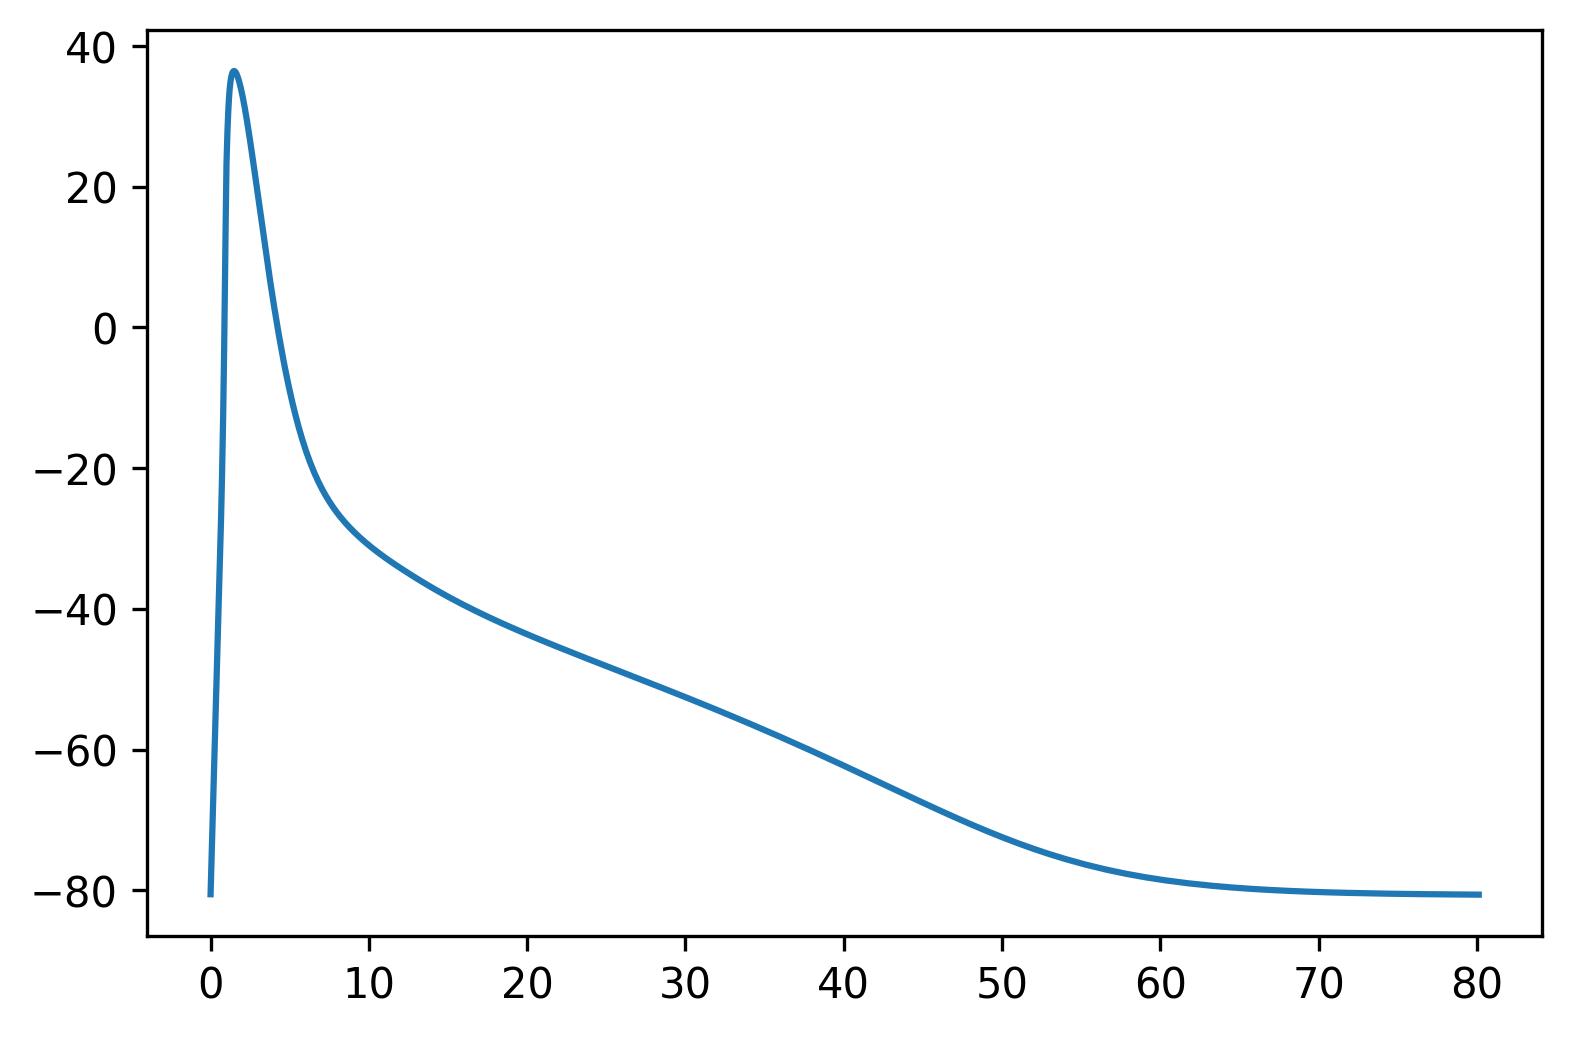

In [40]:
plt.figure(dpi=300)
plt.plot(timespace[:500], output[:500,1])

In [43]:
np.savetxt("lsoda_ans",np.array(list(zip(np.linspace(0,1000,10001),np.interp(np.linspace(0,1000,10001),timespace,output[:,1])))))